In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 8.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=44f6c2b8b63287cef0c0263920a4b7dc3b7bbbdeedd62cdf6b767edb1f93c81a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 3.6 MB/s 
     |████████████████████████████████| 130 kB 12.9 MB/s 
     |████████████████████████████████| 49 kB 8.4 MB/s 
     |████████████████████████████████| 74 kB 4.1 MB/s 
     |████████████████████████████████| 145 kB 77.7 MB/s 
     |████████████████████████████████| 749 kB 61.6 MB/s 
     |███████████████████████████████

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/DL_MASKRCNN/

/content/drive/MyDrive/DL_MASKRCNN


In [17]:
#!unzip data.zip

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("samples1", {}, "./data/train.json", "./data/images")

In [5]:
sample_metadata = MetadataCatalog.get("samples1")
dataset_dicts = DatasetCatalog.get("samples1")

WARNING [01/18 15:51:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/18 15:51:42 d2.data.datasets.coco]: Loaded 50 images in COCO format from ./data/train.json


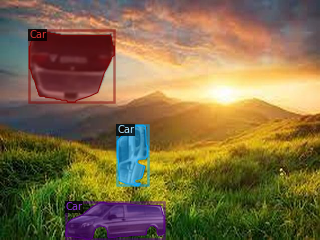

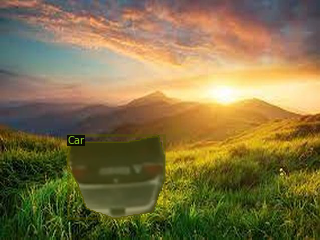

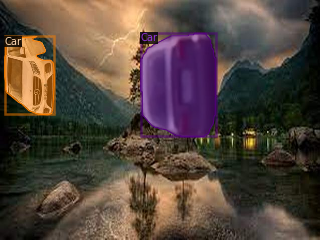

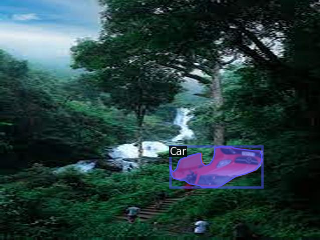

In [32]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [18]:
#!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

In [25]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("samples1",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (Person, Helmet, Car)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/18 16:21:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/18 16:21:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/18 16:21:45 d2.utils.events]:  eta: 0:09:49  iter: 19  total_loss: 2.028  loss_cls: 0.6056  loss_box_reg: 0.7402  loss_mask: 0.6783  loss_rpn_cls: 0.004401  loss_rpn_loc: 0.003852  time: 0.3930  data_time: 0.0151  lr: 3.9962e-05  max_mem: 2679M
[01/18 16:21:53 d2.utils.events]:  eta: 0:09:45  iter: 39  total_loss: 1.749  loss_cls: 0.4531  loss_box_reg: 0.7657  loss_mask: 0.5129  loss_rpn_cls: 0.005924  loss_rpn_loc: 0.004268  time: 0.3938  data_time: 0.0066  lr: 7.9922e-05  max_mem: 2679M
[01/18 16:22:01 d2.utils.events]:  eta: 0:09:42  iter: 59  total_loss: 1.48  loss_cls: 0.3085  loss_box_reg: 0.8089  loss_mask: 0.3613  loss_rpn_cls: 0.002363  loss_rpn_loc: 0.003071  time: 0.3998  data_time: 0.0058  lr: 0.00011988  max_mem: 2679M
[01/18 16:22:10 d2.utils.events]:  eta: 0:09:36  iter: 79  total_loss: 1.19  loss_cls: 0.1957  loss_box_reg: 0.7014  loss_mask: 0.2483  loss_rpn_cls: 0.00178  loss_rpn_loc: 0.003431  time: 0.4047  data_time: 0.0067  lr: 0.00015984  max_mem: 2679M
[01/18 

In [26]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("samples1", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


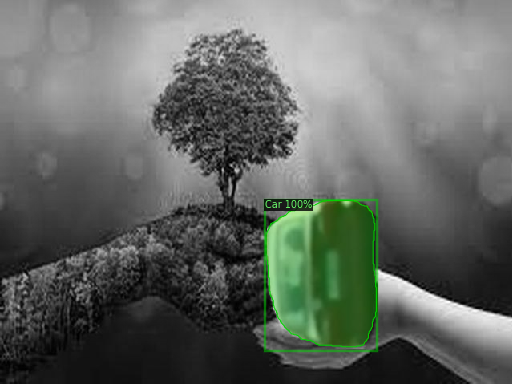

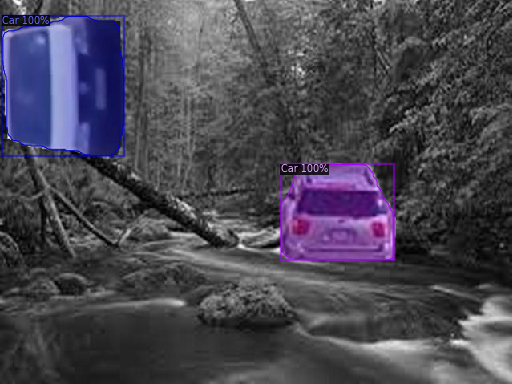

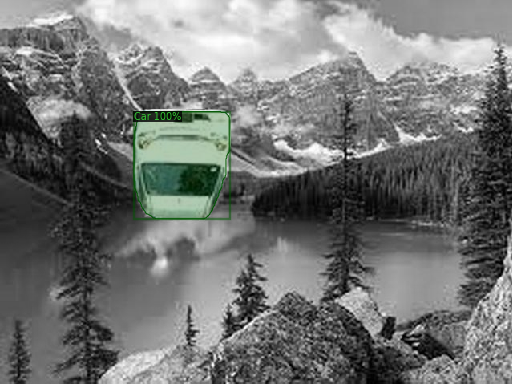

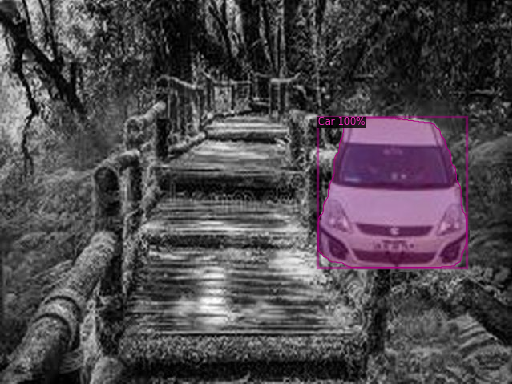

In [31]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [28]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
evaluator = COCOEvaluator("samples1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "samples1")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/18 16:32:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/18 16:32:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/18 16:32:52 d2.data.datasets.coco]: Loaded 50 images in COCO format from ./data/train.json
[01/18 16:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/18 16:32:52 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[01/18 16:32:52 d2.data.common]: Serialized dataset takes 0.09 MiB
[01/18 16:32:52 d2.evaluation.evaluator]: Start inference on 50 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/18 16:32:53 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0013 s/iter. Inference: 0.1028 s/iter. Eval: 0.0017 s/iter. Total: 0.1057 s/iter. ETA=0:00:04
[01/18 16:32:58 d2.evaluation.evaluator]: Total inference time: 0:00:04.859592 (0.107991 s / iter per device, on 1 devices)
[01/18 16:32:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.102926 s / iter per device, on 1 devices)
[01/18 16:32:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/18 16:32:58 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/18 16:32:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/18 16:32:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/18 16:32:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[01/18 16:32:58 d2.evaluation.

OrderedDict([('bbox',
              {'AP': 94.34701113377483,
               'AP50': 99.82013201320132,
               'AP75': 97.94059405940594,
               'APl': 94.04076463115929,
               'APm': 97.64851485148515,
               'APs': nan}),
             ('segm',
              {'AP': 94.5228196684885,
               'AP50': 99.82013201320132,
               'AP75': 99.82013201320132,
               'APl': 94.0978069857975,
               'APm': 97.6085300837776,
               'APs': nan})])

In [19]:
#!unzip test.zip

In [14]:
register_coco_instances("test1", {}, "./test/test.json", "./test/images")

In [29]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
evaluator = COCOEvaluator("test1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "test1")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/18 16:33:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/18 16:33:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/18 16:33:10 d2.data.datasets.coco]: Loaded 50 images in COCO format from ./test/test.json
[01/18 16:33:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/18 16:33:10 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[01/18 16:33:10 d2.data.common]: Serialized dataset takes 0.09 MiB
[01/18 16:33:10 d2.evaluation.evaluator]: Start inference on 50 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/18 16:33:11 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0012 s/iter. Inference: 0.0999 s/iter. Eval: 0.0012 s/iter. Total: 0.1023 s/iter. ETA=0:00:03
[01/18 16:33:16 d2.evaluation.evaluator]: Total inference time: 0:00:04.827079 (0.107268 s / iter per device, on 1 devices)
[01/18 16:33:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.101935 s / iter per device, on 1 devices)
[01/18 16:33:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/18 16:33:16 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/18 16:33:16 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/18 16:33:16 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/18 16:33:16 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[01/18 16:33:16 d2.evaluation.

OrderedDict([('bbox',
              {'AP': 87.92907527588032,
               'AP50': 97.96713713924582,
               'AP75': 94.8430088152201,
               'APl': 87.89168757102878,
               'APm': 91.79632248939178,
               'APs': nan}),
             ('segm',
              {'AP': 90.09128858531201,
               'AP50': 97.96713713924582,
               'AP75': 94.91933166489636,
               'APl': 90.63922563478923,
               'APm': 87.43024302430243,
               'APs': nan})])